# Comparative Analysis between Singapore and Hong Kong

This notebook consists of codes to explore the different districts within each city, finding clusters within each city and determining similarities/ uniqueness between the two cities.  

The key steps are: 1) Dataframe Creation, 2) Coordinates Addition, and 3) District Clustering.

In [1]:
# Commented below lines since packages were installed after first run and hence not required to be rerun
# !conda install -c anaconda beautifulsoup4
# !pip install folium

import pandas as pd
import numpy as np
import re

import requests
from bs4 import BeautifulSoup

from project_lib import Project

from sklearn.cluster import KMeans

import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# Defining Cloud Storage Object credentials
project_id = '826b5988-d60d-46fa-821b-e95d2d17bf36'
project_token = 'p-176e988a0a986e2952b4e6c74ab503525cebda41'

# Defining Foursquare credentials
CLIENT_ID = 'XSOZCHLB5OT4IVJGPRWPTC3FWSA1LCCOXBPNLJ1O3ZI353LD'
CLIENT_SECRET = 'HJY0IEW2HTTM4HKFYDIA1I0ID3JNWR2CFZJJCSJG0JT5IBJC'
VERSION = '20200101'

# Defining Singapore's and Hong Kong's coordinates
sg_lat_lon = [1.3, 103.8]
hk_lat_lon = [22.3, 114.2]

In [2]:
# Defining function to export dataframe to CSV file and store it in Cloud Object Storage

def saveFileInCloud(file_name, df):
    project = Project(None, project_id, project_token)
    project.save_data(file_name=file_name, data=df.to_csv(index=False), overwrite=True)

In [3]:
# Defining function to read CSV file from Cloud Object Storage and return it as dataframe

def readFileFromCloud(file_name):
    project = Project(None, project_id, project_token)
    return pd.read_csv(project.get_file(file_name))

In [4]:
# Defining function to get nearby venues of all districts

def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, radius, limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) 
            for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 'District Latitude', 'District Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [5]:
# Defining function to perform one-hot encoding for nearby recommended venues of all districts

def performOneHotEncoding(df):
    # One-hot encoding
    onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # Add district column back to dataframe
    onehot['District'] = df['District']

    # Move district column to first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]

    # Return grouped rows by district with means of frequency of occurrence of each category
    return onehot.groupby(['District'], sort=False).mean().reset_index()

In [6]:
# Defining function to print each district along with most common venues

def printMostCommonVenues(df, num_top_venues):
    for district in df['District']:
        print("----"+district+"----")
        temp = df[df['District'] == district].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq':2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [7]:
# Defining function to sort most common venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [8]:
# Defining function to display most common venues for each district

def displayMostCommonVenues(df, num_top_venues):
    indicators = ['st', 'nd', 'rd']
    columns = ['District']

    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create new dataframe
    districts_venues_sorted = pd.DataFrame(columns=columns)
    districts_venues_sorted['District'] = df['District']

    for ind in np.arange(df.shape[0]):
        districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return districts_venues_sorted

In [9]:
# Defining function to compute distortions of k-means clustering

def computeDistortions(df, k_range):
    distortions = []
    K = k_range

    for k in K:
        kmeansModel = KMeans(n_clusters=k)
        kmeansModel.fit(df)
        distortions.append(kmeansModel.inertia_)

    return distortions

In [10]:
# Defining function to plot distortions of k-means clustering

def plotDistortions(df, k_range, width_graph, height_graph):
    plt.figure(figsize=(width_graph,height_graph))
    plt.plot(k_range, df, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method Showing Optimal k')
    plt.show()

In [11]:
# Defining function to visualise clusters in map

def visualiseClusters(df, k, loc_lat_lon, zoom_start):
    map_clusters = folium.Map(location=[loc_lat_lon[0], loc_lat_lon[1]], zoom_start=zoom_start)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['District'], df['ClusterLabel']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], 
                            fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

## Part 1: Data Creation

### Part 1.1: Singapore

In [12]:
# Parsing source html page
sg_source = requests.get('https://en.wikipedia.org/wiki/Postal_codes_in_Singapore').text
sg_soup = BeautifulSoup(sg_source, 'html.parser')

# Importing parsed data into dataframe
sg_data = sg_soup.find_all('table', class_='wikitable')
sg_df = pd.read_html(str(sg_data))[0]

# Cleaning dataframe
sg_df.drop(sg_df.columns[1], axis=1, inplace=True)
sg_df.rename(columns={'Postal district':'SGDistrict', 'General location':'GeneralLocation'}, inplace=True)
sg_df.iloc[0,1] = 'Raffles Place, Cecil, Marina Square, People\'s Park' # Updating Marina to Marina Square to get more accurate results via OneMap API
sg_df.iloc[4,1] = 'Pasir Panjang, West Coast Terrace, Clementi' # Updating Hong Leong Garden to West Coast Terrace and Clementi New Town to Clementi to get more accurate results via OneMap API
sg_df.iloc[5,1] = 'High Street, Beach Road' # Updating Beach Road (part) to Beach Road to get more accurate results via OneMap API
sg_df.iloc[7,1] = 'Little India, Farrer Park, Jalan Besar, Lavender Street' # Updating Lavender to Lavender Street to get more accurate results via OneMap API
sg_df.iloc[27,1] = 'Seletar Road' # Updating Seletar to Seletar Road to get more accurate results via OneMap API

sg_df.head()

,SGDistrict,GeneralLocation
0,1,"Raffles Place, Cecil, Marina Square, People's ..."
1,2,"Anson, Tanjong Pagar"
2,3,"Bukit Merah, Queenstown, Tiong Bahru"
3,4,"Telok Blangah, Harbourfront"
4,5,"Pasir Panjang, West Coast Terrace, Clementi"


### Part 1.2: Hong Kong

In [4]:
# Parsing source html page
hk_source = requests.get('https://en.wikipedia.org/wiki/Districts_of_Hong_Kong').text
hk_soup = BeautifulSoup(hk_source, 'html.parser')

# Importing parsed data into dataframe
hk_data = hk_soup.find_all('table', class_='wikitable sortable')
hk_df = pd.read_html(str(hk_data))[0]

# Cleaning dataframe
hk_df.drop([hk_df.columns[1], hk_df.columns[2], hk_df.columns[3], hk_df.columns[4]], axis=1, inplace=True)
hk_df.rename(columns={'District':'HKDistrict'}, inplace=True)

hk_df.head()

,HKDistrict,Region
0,Central and Western,Hong Kong Island
1,Eastern,Hong Kong Island
2,Southern,Hong Kong Island
3,Wan Chai,Hong Kong Island
4,Sham Shui Po,Kowloon


## Part 2: Coordinates Addition

### Part 2.1: Singapore

In [14]:
# Iterating through 'General Locations' and finding their coordinates via OneMap API.
# Note: Multiple locations may be returned via OneMap API. Coordinates of first returned location are used since returned locations are assumed to be near each other.

genloc_lat_lon = []

for row in sg_df.itertuples():
    genloc = row[2]
    searchValList = genloc.split(', ')
    
    for index in range(len(searchValList)):
        searchVal = searchValList[index]
        returnGeom = 'Y'
        getAddrDetails = 'N'
        pageNum = 1
        
        url = 'https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom={}&getAddrDetails={}&pageNum={}'.format(
            searchVal, returnGeom, getAddrDetails, pageNum)
        
        results = requests.get(url).json()
        
        if results['found'] == 0:
            genloc_lat_lon.append([genloc, searchVal, 0, 0])
        else:
            searched_loc = results['results'][0]['SEARCHVAL']
            searched_lat = results['results'][0]['LATITUDE']
            searched_lon = results['results'][0]['LONGITUDE']
            
            genloc_lat_lon.append([genloc, searched_loc, searched_lat, searched_lon])

genloc_lat_lon = pd.DataFrame(genloc_lat_lon)
genloc_lat_lon.columns = ['GeneralLocation', 'SearchedLocation', 'SearchedLatitude', 'SearchedLongitude']
genloc_lat_lon = genloc_lat_lon.astype({'SearchedLatitude':float, 'SearchedLongitude':float})

genloc_lat_lon.head()

,GeneralLocation,SearchedLocation,SearchedLatitude,SearchedLongitude
0,"Raffles Place, Cecil, Marina Square, People's ...",RAFFLES PLACE,1.283933,103.851463
1,"Raffles Place, Cecil, Marina Square, People's ...",158 CECIL STREET SINGAPORE 069545,1.279789,103.848043
2,"Raffles Place, Cecil, Marina Square, People's ...",MARINA SQUARE,1.291040,103.857624
3,"Raffles Place, Cecil, Marina Square, People's ...",PEOPLE'S PARK CENTRE,1.285758,103.843930
4,"Anson, Tanjong Pagar",79 ANSON ROAD SINGAPORE 079906,1.274098,103.845669


In [15]:
# Determining centroids of general locations for each postal district
genloc_lat_lon_grouped = genloc_lat_lon.groupby('GeneralLocation', sort=False)['SearchedLatitude', 'SearchedLongitude'].mean()
genloc_lat_lon_grouped.head()

,SearchedLatitude,SearchedLongitude
GeneralLocation,,
"Raffles Place, Cecil, Marina Square, People's Park",1.285130,103.850265
"Anson, Tanjong Pagar",1.274526,103.843923
"Bukit Merah, Queenstown, Tiong Bahru",1.285461,103.820705
"Telok Blangah, Harbourfront",1.269926,103.813697
"Pasir Panjang, West Coast Terrace, Clementi",1.310088,103.767941


In [16]:
# Appending coordinates of centroids to original dataframe
sg_df = sg_df.join(genloc_lat_lon_grouped, on='GeneralLocation')
sg_df.head()

,SGDistrict,GeneralLocation,SearchedLatitude,SearchedLongitude
0,1,"Raffles Place, Cecil, Marina Square, People's ...",1.285130,103.850265
1,2,"Anson, Tanjong Pagar",1.274526,103.843923
2,3,"Bukit Merah, Queenstown, Tiong Bahru",1.285461,103.820705
3,4,"Telok Blangah, Harbourfront",1.269926,103.813697
4,5,"Pasir Panjang, West Coast Terrace, Clementi",1.310088,103.767941


In [27]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('sg_df.csv', sg_df)

{'file_name': 'sg_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-2akc59vlb1riwp',
 'asset_id': '6bd1b831-7eec-4f4f-b41d-615703948ca3'}

### Part 2.2: Hong Kong

In [5]:
# Determining URLs of html pages with details of districts

hk_districts_links = []

for link in hk_soup.find_all('a', href=re.compile('^/wiki/.*District$|^/wiki/.*District_\(Hong_Kong\)$')):
    link_text = link.get_text()
    link_url = 'https://en.wikipedia.org' + link.get('href')
    
    if 'District' not in link_text: # Preventing redundant entries from being appended to list
        hk_districts_links.append([link_text, link_url])

hk_districts_links = pd.DataFrame(hk_districts_links, columns=['HKDistrict', 'URL'])
hk_districts_links = hk_districts_links.drop_duplicates()
hk_districts_links = hk_districts_links[hk_districts_links.HKDistrict != 'Mong Kok'] # Removing Mong Kok as it is no longer a district
hk_districts_links = hk_districts_links[hk_districts_links.HKDistrict != 'Yau Tsim'] # Removing Yau Tsim as it is no longer a district
hk_districts_links.reset_index(drop=True)

hk_districts_links.head()

,HKDistrict,URL
0,Islands,https://en.wikipedia.org/wiki/Islands_District
1,Kwai Tsing,https://en.wikipedia.org/wiki/Kwai_Tsing_District
2,North,https://en.wikipedia.org/wiki/North_District_(...
3,Sai Kung,https://en.wikipedia.org/wiki/Sai_Kung_District
4,Sha Tin,https://en.wikipedia.org/wiki/Sha_Tin_District


In [15]:
# Crawling through html pages of districts and grabbing their coordinates

hk_districts_lat_lon = []

for row in hk_districts_links.itertuples():
    hk_district_source = requests.get(row[2]).text
    hk_district_soup = BeautifulSoup(hk_district_source, 'html.parser')
    script_text = str(hk_district_soup.find('script'))
    
    lat_lon = re.search('"wgCoordinates".*},|"wgCoordinates".*},\n|"wgCoordinates".*\n.*},', script_text)
    lat_lon = re.findall('[0-9]+\.[0-9]+', lat_lon.group())
    
    hk_districts_lat_lon.append([row[1], lat_lon[0], lat_lon[1]])

hk_districts_lat_lon = pd.DataFrame(hk_districts_lat_lon, columns=['HKDistrict', 'Latitude', 'Longitude'])
hk_districts_lat_lon = hk_districts_lat_lon.astype({'HKDistrict':str, 'Latitude':float, 'Longitude':float})
hk_districts_lat_lon.set_index('HKDistrict', inplace=True)

hk_districts_lat_lon.head()

,Latitude,Longitude
HKDistrict,,
Islands,22.26114,113.94608
Kwai Tsing,22.35488,114.08401
North,22.49471,114.13812
Sai Kung,22.38143,114.27052
Sha Tin,22.38715,114.19534


In [16]:
# Appending coordinates to original dataframe
hk_df = hk_df.join(hk_districts_lat_lon, on='HKDistrict')
hk_df.head()

,HKDistrict,Region,Latitude,Longitude
0,Central and Western,Hong Kong Island,22.28666,114.15497
1,Eastern,Hong Kong Island,22.28411,114.22414
2,Southern,Hong Kong Island,22.24725,114.15884
3,Wan Chai,Hong Kong Island,22.27968,114.17168
4,Sham Shui Po,Kowloon,22.33074,114.16220


In [17]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('hk_df.csv', hk_df)

{'file_name': 'hk_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-2akc59vlb1riwp',
 'asset_id': 'aec7901f-c06b-487e-acaf-38275eecd4f5'}

## Part 3: District Clustering

The following sections break the comparative analysis between Singapore and Hong Kong into several steps, namely:  
  
(i) exploring districts in both cities by retrieving information on nearby recommended venues from Foursquare  
(ii) analysing each districts by determining its most recommended venue categories  
(iii) clustering districts by k-means clustering and visualising clusters in a Folium map  
(iv) examining districts by evaluating commonalities between their most recommended venue categories and providing descriptive names to clusters

### Part 3.1: Explore Districts

#### Part 3.1.1: Singapore

In [37]:
# Getting nearby recommended venues from Foursquare

sg_df = readFileFromCloud('sg_df.csv')

sg_df['DistrictDesc'] = sg_df['SGDistrict'].astype(str) + ' - ' + sg_df['GeneralLocation']

sg_venues = getNearbyVenues(names=sg_df['DistrictDesc'], latitudes=sg_df['SearchedLatitude'], longitudes=sg_df['SearchedLongitude'], 
                            radius=1500, limit=100)

print('{} rows and {} columns'.format(sg_venues.shape[0], sg_venues.shape[1]))
print('{} unique categories'.format(len(sg_venues['Venue Category'].unique())))
sg_venues.head()

2264 rows and 7 columns
249 unique categories


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.28513,103.850265,CITY Hot Pot Shabu shabu,1.284173,103.851585,Hotpot Restaurant
1,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.28513,103.850265,Ritual Gym,1.285965,103.848651,Gym
2,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.28513,103.850265,Sabaai Sabaai Traditional Thai Massage,1.286964,103.849512,Massage Studio
3,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.28513,103.850265,Virgin Active,1.284608,103.850815,Gym / Fitness Center
4,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.28513,103.850265,Amoy Hotel,1.283118,103.848539,Hotel


In [38]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('sg_venues.csv', sg_venues)

#### Part 3.1.2: Hong Kong

In [15]:
# Getting nearby recommended venues from Foursquare

hk_df = readFileFromCloud('hk_df.csv')

hk_venues = getNearbyVenues(names=hk_df['HKDistrict'], latitudes=hk_df['Latitude'], longitudes=hk_df['Longitude'],
                            radius=1500, limit=100)

print('{} rows and {} columns'.format(hk_venues.shape[0], hk_venues.shape[1]))
print('{} unique categories'.format(len(hk_venues['Venue Category'].unique())))
hk_venues.head()

1309 rows and 7 columns
194 unique categories


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central and Western,22.28666,114.15497,Four Seasons Hotel Hong Kong (香港四季酒店),22.286554,114.156929,Hotel
1,Central and Western,22.28666,114.15497,Samsen (泰館),22.285082,114.152286,Thai Restaurant
2,Central and Western,22.28666,114.15497,Godenya,22.284673,114.153195,Japanese Restaurant
3,Central and Western,22.28666,114.15497,IFC Mall Ferry Pier Walkway,22.287095,114.157675,Scenic Lookout
4,Central and Western,22.28666,114.15497,The Spa at Four Seasons,22.286279,114.157623,Spa


In [16]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('hk_venues.csv', hk_venues)

{'file_name': 'hk_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-2akc59vlb1riwp',
 'asset_id': 'a5c1aadf-6f90-47d0-ac06-ba7f9eda3827'}

### Part 3.2: Analyse Each District

#### Part 3.2.1: Singapore

In [11]:
# Performing one-hot encoding for nearby recommended venues of all districts

# Create dataframe from CSV file
sg_venues = readFileFromCloud('sg_venues.csv')

# Perform one-hot encoding
sg_grouped = performOneHotEncoding(sg_venues)

print('{} rows and {} columns'.format(sg_grouped.shape[0], sg_grouped.shape[1]))
sg_grouped.head()

28 rows and 250 columns


,District,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,"1 - Raffles Place, Cecil, Marina Square, Peopl...",0.0,0.00,0.010000,0.01,0.000000,0.010000,0.0,0.00,0.0,...,0.00,0.06,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0
1,"2 - Anson, Tanjong Pagar",0.0,0.00,0.000000,0.00,0.000000,0.010000,0.0,0.02,0.0,...,0.00,0.00,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0
2,"3 - Bukit Merah, Queenstown, Tiong Bahru",0.0,0.00,0.000000,0.00,0.000000,0.010000,0.0,0.00,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.0
3,"4 - Telok Blangah, Harbourfront",0.0,0.01,0.020000,0.00,0.000000,0.010000,0.0,0.00,0.0,...,0.01,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0
4,"5 - Pasir Panjang, West Coast Terrace, Clementi",0.0,0.00,0.010417,0.00,0.010417,0.041667,0.0,0.00,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0


In [12]:
# Printing each district along with most common venues
printMostCommonVenues(sg_grouped, 5)

----1 - Raffles Place, Cecil, Marina Square, People's Park----
                venue  freq
0               Hotel  0.07
1          Waterfront  0.06
2  Seafood Restaurant  0.04
3         Event Space  0.03
4        Cocktail Bar  0.03


----2 - Anson, Tanjong Pagar----
                 venue  freq
0  Japanese Restaurant  0.09
1          Coffee Shop  0.07
2                Hotel  0.06
3                 Café  0.04
4           Food Court  0.04


----3 - Bukit Merah, Queenstown, Tiong Bahru----
                venue  freq
0  Chinese Restaurant  0.12
1                Café  0.09
2          Food Court  0.08
3                Park  0.06
4         Coffee Shop  0.05


----4 - Telok Blangah, Harbourfront----
                venue  freq
0  Chinese Restaurant  0.07
1      Scenic Lookout  0.05
2          Food Court  0.04
3               Trail  0.04
4                Café  0.04


----5 - Pasir Panjang, West Coast Terrace, Clementi----
                venue  freq
0         Coffee Shop  0.07
1                

In [13]:
# Displaying most common venues for each district
sg_most_common_venues = displayMostCommonVenues(sg_grouped, 10)

print('{} rows and {} columns'.format(sg_most_common_venues.shape[0], sg_most_common_venues.shape[1]))
sg_most_common_venues.head()

28 rows and 11 columns


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1 - Raffles Place, Cecil, Marina Square, Peopl...",Hotel,Waterfront,Seafood Restaurant,Cocktail Bar,Event Space,Japanese Restaurant,Plaza,Concert Hall,Spanish Restaurant,Performing Arts Venue
1,"2 - Anson, Tanjong Pagar",Japanese Restaurant,Coffee Shop,Hotel,Café,Food Court,Cocktail Bar,Bakery,Tapas Restaurant,Spanish Restaurant,Gym / Fitness Center
2,"3 - Bukit Merah, Queenstown, Tiong Bahru",Chinese Restaurant,Café,Food Court,Park,Bakery,Coffee Shop,Noodle House,Hainan Restaurant,Indian Restaurant,Hotel
3,"4 - Telok Blangah, Harbourfront",Chinese Restaurant,Scenic Lookout,Trail,Café,Food Court,Multiplex,Park,Clothing Store,Pool,Japanese Restaurant
4,"5 - Pasir Panjang, West Coast Terrace, Clementi",Coffee Shop,Food Court,Café,Bakery,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Park,Dessert Shop,Sandwich Place


In [14]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('sg_grouped.csv', sg_grouped)
saveFileInCloud('sg_most_common_venues.csv', sg_most_common_venues)

#### Part 3.2.2: Hong Kong

In [15]:
# Performing one-hot encoding for nearby recommended venues of all districts

# Create dataframe from CSV file
hk_venues = readFileFromCloud('hk_venues.csv')

# Perform one-hot encoding
hk_grouped = performOneHotEncoding(hk_venues)

print('{} rows and {} columns'.format(hk_grouped.shape[0], hk_grouped.shape[1]))
hk_grouped.head()

18 rows and 195 columns


,District,Accessories Store,African Restaurant,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Central and Western,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01000,0.01,0.01,0.010000,0.00,0.020000,0.0,0.00,0.00
1,Eastern,0.000000,0.000000,0.00,0.000000,0.00,0.01,0.00,0.00,0.00,...,0.01,0.01000,0.00,0.00,0.000000,0.00,0.010000,0.0,0.00,0.00
2,Southern,0.012195,0.012195,0.00,0.012195,0.00,0.00,0.00,0.00,0.00,...,0.00,0.02439,0.00,0.00,0.012195,0.00,0.012195,0.0,0.00,0.00
3,Wan Chai,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.02,0.02000,0.01,0.00,0.000000,0.00,0.020000,0.0,0.01,0.01
4,Sham Shui Po,0.000000,0.000000,0.00,0.000000,0.00,0.01,0.00,0.00,0.00,...,0.01,0.01000,0.00,0.00,0.000000,0.01,0.000000,0.0,0.00,0.00


In [16]:
# Printing each district along with most common venues
printMostCommonVenues(hk_grouped, 5)

----Central and Western----
                 venue  freq
0  Japanese Restaurant  0.08
1    French Restaurant  0.07
2                 Café  0.05
3          Coffee Shop  0.04
4         Cocktail Bar  0.04


----Eastern----
                 venue  freq
0                 Café  0.08
1  Japanese Restaurant  0.07
2   Chinese Restaurant  0.06
3          Coffee Shop  0.05
4                 Park  0.05


----Southern----
                    venue  freq
0      Chinese Restaurant  0.10
1  Furniture / Home Store  0.05
2                    Café  0.05
3                    Park  0.05
4             Coffee Shop  0.04


----Wan Chai----
                venue  freq
0               Hotel  0.08
1                Café  0.07
2         Coffee Shop  0.05
3  Italian Restaurant  0.05
4  Chinese Restaurant  0.04


----Sham Shui Po----
                  venue  freq
0          Noodle House  0.10
1    Chinese Restaurant  0.07
2          Dessert Shop  0.06
3        Cha Chaan Teng  0.05
4  Hong Kong Restaurant  0.05


---

In [17]:
# Displaying most common venues for each district
hk_most_common_venues = displayMostCommonVenues(hk_grouped, 10)

print('{} rows and {} columns'.format(hk_most_common_venues.shape[0], hk_most_common_venues.shape[1]))
hk_most_common_venues.head()

18 rows and 11 columns


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Japanese Restaurant,French Restaurant,Café,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Thai Restaurant,Yoga Studio
1,Eastern,Café,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Park,Department Store,Noodle House,Seafood Restaurant,French Restaurant,Shopping Mall
2,Southern,Chinese Restaurant,Furniture / Home Store,Café,Park,Restaurant,Thai Restaurant,Coffee Shop,Fast Food Restaurant,Vietnamese Restaurant,Trail
3,Wan Chai,Hotel,Café,Coffee Shop,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Szechuan Restaurant,Burger Joint,Seafood Restaurant,Snack Place
4,Sham Shui Po,Noodle House,Chinese Restaurant,Dessert Shop,Hong Kong Restaurant,Cha Chaan Teng,Café,Dim Sum Restaurant,Coffee Shop,Malay Restaurant,Italian Restaurant


In [18]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('hk_grouped.csv', hk_grouped)
saveFileInCloud('hk_most_common_venues.csv', hk_most_common_venues)

### Part 3.3: Cluster Districts

#### Part 3.3.1: Singapore

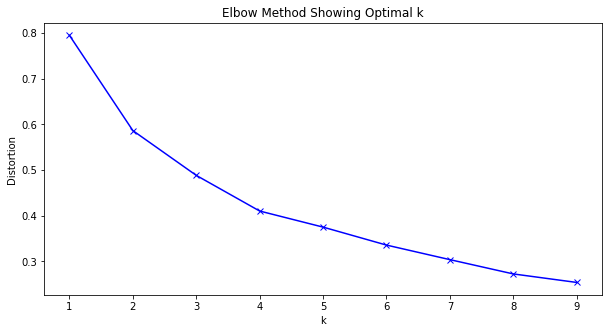

In [12]:
# Determining optimal number of clusters for k-means clustering

sg_grouped = readFileFromCloud('sg_grouped.csv')
sg_grouped_clustering = sg_grouped.drop('District', axis=1)
k_range = range(1,10)

distortions = computeDistortions(sg_grouped_clustering, k_range)
plotDistortions(distortions, k_range, 10, 5)

In [13]:
# Running k-means to cluster districts into 4 clusters (note: elbow method indicates optimal k is 4)
k = 4
kmeansModel = KMeans(n_clusters=k).fit(sg_grouped_clustering)
kmeansModel.labels_[0:]

array([0, 0, 2, 2, 3, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3,
       3, 1, 3, 2, 3, 3], dtype=int32)

In [14]:
# Creating new dataframe that includes clusters as well as most common venues for each district

sg_most_common_venues = readFileFromCloud('sg_most_common_venues.csv')
sg_most_common_venues.insert(0, 'ClusterLabel', kmeansModel.labels_)

sg_df = readFileFromCloud('sg_df.csv')
sg_df['District'] = sg_df['SGDistrict'].astype(str) + ' - ' + sg_df['GeneralLocation']

fixed_columns = [sg_df.columns[-1]] + list(sg_df.columns[2:-1])
sg_df = sg_df[fixed_columns]

sg_merged = sg_df.join(sg_most_common_venues.set_index('District'), on='District')
sg_merged.rename(columns={'SearchedLatitude':'Latitude', 'SearchedLongitude':'Longitude'}, inplace=True)
sg_merged = sg_merged.astype({'ClusterLabel':int})
sg_merged = sg_merged.reset_index(drop=True)

print('{} rows and {} columns'.format(sg_merged.shape[0], sg_merged.shape[1]))
sg_merged.head()

28 rows and 14 columns


,District,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1 - Raffles Place, Cecil, Marina Square, Peopl...",1.285130,103.850265,0,Hotel,Waterfront,Seafood Restaurant,Cocktail Bar,Event Space,Japanese Restaurant,Plaza,Concert Hall,Spanish Restaurant,Performing Arts Venue
1,"2 - Anson, Tanjong Pagar",1.274526,103.843923,0,Japanese Restaurant,Coffee Shop,Hotel,Café,Food Court,Cocktail Bar,Bakery,Tapas Restaurant,Spanish Restaurant,Gym / Fitness Center
2,"3 - Bukit Merah, Queenstown, Tiong Bahru",1.285461,103.820705,2,Chinese Restaurant,Café,Food Court,Park,Bakery,Coffee Shop,Noodle House,Hainan Restaurant,Indian Restaurant,Hotel
3,"4 - Telok Blangah, Harbourfront",1.269926,103.813697,2,Chinese Restaurant,Scenic Lookout,Trail,Café,Food Court,Multiplex,Park,Clothing Store,Pool,Japanese Restaurant
4,"5 - Pasir Panjang, West Coast Terrace, Clementi",1.310088,103.767941,3,Coffee Shop,Food Court,Café,Bakery,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Park,Dessert Shop,Sandwich Place


In [15]:
# Visualising resulting clusters on map
map_clusters = visualiseClusters(sg_merged, k, sg_lat_lon, 11)
map_clusters

In [16]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('sg_merged.csv', sg_merged)

#### Part 3.3.2: Hong Kong

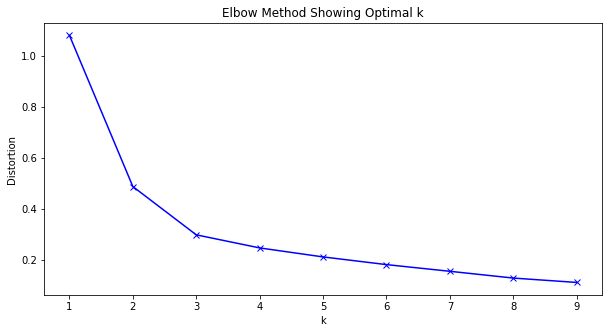

In [17]:
# Determining optimal number of clusters for k-means clustering

hk_grouped = readFileFromCloud('hk_grouped.csv')
hk_grouped_clustering = hk_grouped.drop('District', axis=1)
k_range = range(1,10)

distortions = computeDistortions(hk_grouped_clustering, k_range)
plotDistortions(distortions, k_range, 10, 5)

In [18]:
# Running k-means to cluster districts into 3 clusters (note: elbow method indicates optimal k is 3)
k = 3
kmeansModel = KMeans(n_clusters=k).fit(hk_grouped_clustering)
kmeansModel.labels_[0:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [19]:
# Creating new dataframe that includes clusters as well as most common venues for each district

hk_most_common_venues = readFileFromCloud('hk_most_common_venues.csv')
hk_most_common_venues.insert(0, 'ClusterLabel', kmeansModel.labels_)

hk_df = readFileFromCloud('hk_df.csv')
hk_df.rename(columns={'HKDistrict':'District'}, inplace=True)

hk_merged = hk_df.join(hk_most_common_venues.set_index('District'), on='District')
hk_merged = hk_merged.astype({'ClusterLabel':int})
hk_merged = hk_merged.reset_index(drop=True)

print('{} rows and {} columns'.format(hk_merged.shape[0], hk_merged.shape[1]))
hk_merged.head()

18 rows and 15 columns


,District,Region,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Hong Kong Island,22.28666,114.15497,0,Japanese Restaurant,French Restaurant,Café,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Thai Restaurant,Yoga Studio
1,Eastern,Hong Kong Island,22.28411,114.22414,0,Café,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Park,Department Store,Noodle House,Seafood Restaurant,French Restaurant,Shopping Mall
2,Southern,Hong Kong Island,22.24725,114.15884,0,Chinese Restaurant,Furniture / Home Store,Café,Park,Restaurant,Thai Restaurant,Coffee Shop,Fast Food Restaurant,Vietnamese Restaurant,Trail
3,Wan Chai,Hong Kong Island,22.27968,114.17168,0,Hotel,Café,Coffee Shop,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Szechuan Restaurant,Burger Joint,Seafood Restaurant,Snack Place
4,Sham Shui Po,Kowloon,22.33074,114.16220,0,Noodle House,Chinese Restaurant,Dessert Shop,Hong Kong Restaurant,Cha Chaan Teng,Café,Dim Sum Restaurant,Coffee Shop,Malay Restaurant,Italian Restaurant


In [20]:
# Visualising resulting clusters on map
map_clusters = visualiseClusters(hk_merged, k, hk_lat_lon, 11)
map_clusters

In [21]:
# Exporting dataframe to CSV file and storing it in Cloud Object Storage
saveFileInCloud('hk_merged.csv', hk_merged)

### Part 3.4: Examine Clusters

#### Part 3.4.1: Singapore

In [ ]:
sg_merged = readFileFromCloud('sg_merged.csv')

#### Cluster 1

In [23]:
sg_merged.loc[sg_merged['ClusterLabel'] == 0, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1 - Raffles Place, Cecil, Marina Square, Peopl...",Hotel,Waterfront,Seafood Restaurant,Cocktail Bar,Event Space,Japanese Restaurant,Plaza,Concert Hall,Spanish Restaurant,Performing Arts Venue
1,"2 - Anson, Tanjong Pagar",Japanese Restaurant,Coffee Shop,Hotel,Café,Food Court,Cocktail Bar,Bakery,Tapas Restaurant,Spanish Restaurant,Gym / Fitness Center
5,"6 - High Street, Beach Road",Hotel,Shopping Mall,Cocktail Bar,Event Space,Italian Restaurant,Café,Japanese Restaurant,Coffee Shop,Bakery,Beer Bar
6,"7 - Middle Road, Golden Mile",Hotel,Café,Thai Restaurant,Chinese Restaurant,Cocktail Bar,Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Event Space
8,"9 - Orchard, Cairnhill, River Valley",Hotel,Shopping Mall,Japanese Restaurant,Clothing Store,Bakery,Yoga Studio,Wine Bar,Café,Cosmetics Shop,Coffee Shop


#### Cluster 2

In [24]:
sg_merged.loc[sg_merged['ClusterLabel'] == 1, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"24 - Lim Chu Kang, Tengah",Farm,Garden Center,Spa,Café,Farmers Market,Chinese Restaurant,Flower Shop,Zoo Exhibit,Food,Food Court


#### Cluster 3

In [25]:
sg_merged.loc[sg_merged['ClusterLabel'] == 2, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"3 - Bukit Merah, Queenstown, Tiong Bahru",Chinese Restaurant,Café,Food Court,Park,Bakery,Coffee Shop,Noodle House,Hainan Restaurant,Indian Restaurant,Hotel
3,"4 - Telok Blangah, Harbourfront",Chinese Restaurant,Scenic Lookout,Trail,Café,Food Court,Multiplex,Park,Clothing Store,Pool,Japanese Restaurant
7,"8 - Little India, Farrer Park, Jalan Besar, La...",Indian Restaurant,Chinese Restaurant,Café,Bakery,Thai Restaurant,Coffee Shop,Hotel,Restaurant,Vietnamese Restaurant,Italian Restaurant
9,"10 - Ardmore, Bukit Timah, Holland Road, Tanglin",Bakery,Chinese Restaurant,Café,Ice Cream Shop,Food Court,Bar,Supermarket,Asian Restaurant,Thai Restaurant,Noodle House
10,"11 - Watten Estate, Novena, Thomson",Café,Chinese Restaurant,Flower Shop,Trail,Spa,Bakery,Thai Restaurant,Ice Cream Shop,Dessert Shop,Supermarket
11,"12 - Balestier, Toa Payoh, Serangoon",Chinese Restaurant,Food Court,Hotel,Asian Restaurant,Noodle House,Dessert Shop,Coffee Shop,Bakery,Seafood Restaurant,Supermarket
12,"13 - Macpherson, Braddell",Chinese Restaurant,Coffee Shop,Asian Restaurant,Bakery,Convenience Store,Noodle House,Snack Place,Market,Seafood Restaurant,Gym
13,"14 - Geylang, Eunos",Chinese Restaurant,Asian Restaurant,Food Court,Noodle House,Vegetarian / Vegan Restaurant,Multiplex,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Ice Cream Shop
14,"15 - Katong, Joo Chiat, Amber Road",Chinese Restaurant,Asian Restaurant,Indian Restaurant,Italian Restaurant,Hotel,Coffee Shop,Noodle House,Bakery,Multiplex,Japanese Restaurant
19,"20 - Bishan, Ang Mo Kio",Chinese Restaurant,Coffee Shop,Food Court,Café,Japanese Restaurant,Thai Restaurant,Ice Cream Shop,Fast Food Restaurant,Supermarket,Spa


#### Cluster 4

In [26]:
sg_merged.loc[sg_merged['ClusterLabel'] == 3, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"5 - Pasir Panjang, West Coast Terrace, Clementi",Coffee Shop,Food Court,Café,Bakery,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Park,Dessert Shop,Sandwich Place
15,"16 - Bedok, Upper East Coast, Eastwood, Kew Drive",Food Court,Coffee Shop,Noodle House,Asian Restaurant,Chinese Restaurant,Malay Restaurant,Café,Dessert Shop,Beach,Playground
16,"17 - Loyang, Changi",Coffee Shop,Supermarket,Café,Snack Place,Bus Station,Asian Restaurant,Thai Restaurant,Fast Food Restaurant,Chinese Restaurant,Resort
17,"18 - Simei, Tampines, Pasir Ris",Coffee Shop,Bakery,Café,Gym,Supermarket,Thai Restaurant,Fried Chicken Joint,Japanese Restaurant,Gym / Fitness Center,Clothing Store
18,"19 - Serangoon Garden, Hougang, Punggol",Coffee Shop,Food Court,Bus Station,Fast Food Restaurant,Asian Restaurant,Café,Gym,Basketball Court,Supermarket,Sandwich Place
21,"22 - Jurong, Tuas",Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Food Court,Coffee Shop,Dessert Shop,Exhibit,Shopping Mall
22,"23 - Hillview, Dairy Farm, Bukit Panjang, Choa...",Coffee Shop,Food Court,Fast Food Restaurant,Supermarket,Park,Asian Restaurant,Shopping Mall,Sushi Restaurant,Noodle House,Bus Station
24,"25 - Kranji, Woodgrove, Woodlands",Racetrack,Food Court,Grocery Store,Coffee Shop,Bakery,Gaming Cafe,Monument / Landmark,Food,Go Kart Track,Hainan Restaurant
26,"27 - Yishun, Sembawang",Coffee Shop,Chinese Restaurant,Indian Restaurant,Asian Restaurant,Fried Chicken Joint,Thai Restaurant,Café,Hainan Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant
27,28 - Seletar Road,Food Court,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Café,Supermarket,Dessert Shop,American Restaurant,Shopping Mall,Sandwich Place


#### Part 3.4.2: Hong Kong

In [27]:
hk_merged = readFileFromCloud('hk_merged.csv')

#### Cluster 1

In [28]:
hk_merged.loc[hk_merged['ClusterLabel'] == 0, hk_merged.columns[[0] + list(range(5, hk_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Japanese Restaurant,French Restaurant,Café,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Thai Restaurant,Yoga Studio
1,Eastern,Café,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Park,Department Store,Noodle House,Seafood Restaurant,French Restaurant,Shopping Mall
2,Southern,Chinese Restaurant,Furniture / Home Store,Café,Park,Restaurant,Thai Restaurant,Coffee Shop,Fast Food Restaurant,Vietnamese Restaurant,Trail
3,Wan Chai,Hotel,Café,Coffee Shop,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Szechuan Restaurant,Burger Joint,Seafood Restaurant,Snack Place
4,Sham Shui Po,Noodle House,Chinese Restaurant,Dessert Shop,Hong Kong Restaurant,Cha Chaan Teng,Café,Dim Sum Restaurant,Coffee Shop,Malay Restaurant,Italian Restaurant
5,Kowloon City,Coffee Shop,Dessert Shop,Thai Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Hotel,Cha Chaan Teng,Noodle House,Asian Restaurant
6,Kwun Tong,Chinese Restaurant,Coffee Shop,Park,Cha Chaan Teng,Café,Hong Kong Restaurant,Hotel,Noodle House,Shopping Mall,Hakka Restaurant
7,Wong Tai Sin,Dessert Shop,Coffee Shop,Thai Restaurant,Chinese Restaurant,Fast Food Restaurant,Café,Cha Chaan Teng,Noodle House,Asian Restaurant,Cantonese Restaurant
8,Yau Tsim Mong,Coffee Shop,Noodle House,Cha Chaan Teng,Dim Sum Restaurant,Hotel,Hong Kong Restaurant,Beer Bar,Cantonese Restaurant,Dumpling Restaurant,Toy / Game Store
11,North,Fast Food Restaurant,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Noodle House,Burger Joint,Café,Shopping Mall,Metro Station,Cha Chaan Teng


#### Cluster 2

In [29]:
hk_merged.loc[hk_merged['ClusterLabel'] == 1, hk_merged.columns[[0] + list(range(5, hk_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Islands,Trail,Mountain,Zoo,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


#### Cluster 3

In [30]:
hk_merged.loc[hk_merged['ClusterLabel'] == 2, hk_merged.columns[[0] + list(range(5, hk_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Kwai Tsing,Scenic Lookout,Bus Station,Café,Beach,Trail,Electronics Store,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
